## Задача 1. Линейная регрессия, метод градиентного спуска

Самостоятельно реализовать функцию gradient_descent(X, y), которая по заданной обучающей выборке обучает модель линейной регрессии, оптимизируя функционал методом градиентного спуска (Batch Gradient Descent, GD) и возвращая вектор весов w. В качестве функционала можно выбрать, например, функцию ошибок MSE + -регуляризатор. Использовать матрично-векторные операции для вычисления градиента.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

Набор данных об опоссумах, состоящий из девяти морфометрических измерений каждого из 104 горных опоссумов, отловленных в семи местах от Южной Виктории до центрального Квинсленда. Целевая переменная - длина головы (hdlngth) в мм.

*   case - номер наблюдения
*   site - Номер места, где был пойман опоссум.
*   Pop - поселение либо Vic (Виктория), либо другое (Новый Южный Уэльс или Квинсленд).
*   sex - Пол: m (мужской) или f (женский).
*   age - Возраст.
*   hdlngth - Длина головы, мм.
*   skullw - Ширина черепа, мм.
*   totlngth - Общая длина, см.
*   taill - Длина хвоста, см.
*   footlgth - длина ноги, см.
*   earconch - длина ушной раковины
*   eye - расстояние от медиального угла глаза до латерального края правого глаза
*   chest - обхват груди (в см)
*   belly - обхват живота (в см)

















In [2]:
df = pd.read_csv('possum.csv')

In [3]:
df.head()

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


In [4]:
df.shape

(104, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   case      104 non-null    int64  
 1   site      104 non-null    int64  
 2   Pop       104 non-null    object 
 3   sex       104 non-null    object 
 4   age       102 non-null    float64
 5   hdlngth   104 non-null    float64
 6   skullw    104 non-null    float64
 7   totlngth  104 non-null    float64
 8   taill     104 non-null    float64
 9   footlgth  103 non-null    float64
 10  earconch  104 non-null    float64
 11  eye       104 non-null    float64
 12  chest     104 non-null    float64
 13  belly     104 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 11.5+ KB


In [6]:
df.columns = ['_'.join(col.split(' ')).lower() for col in df.columns]

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
case,104.0,52.500000,30.166206,1.0,26.750,52.50,78.250,104.0
site,104.0,3.625000,2.349086,1.0,1.000,3.00,6.000,7.0
age,102.0,3.833333,1.909244,1.0,2.250,3.00,5.000,9.0
hdlngth,104.0,92.602885,3.573349,82.5,90.675,92.80,94.725,103.1
skullw,104.0,56.883654,3.113426,50.0,54.975,56.35,58.100,68.6
totlngth,104.0,87.088462,4.310549,75.0,84.000,88.00,90.000,96.5
taill,104.0,37.009615,1.959518,32.0,35.875,37.00,38.000,43.0
footlgth,103.0,68.459223,4.395306,60.3,64.600,68.00,72.500,77.9
earconch,104.0,48.130769,4.109380,40.3,44.800,46.80,52.000,56.2
eye,104.0,15.046154,1.050374,12.8,14.400,14.90,15.725,17.8


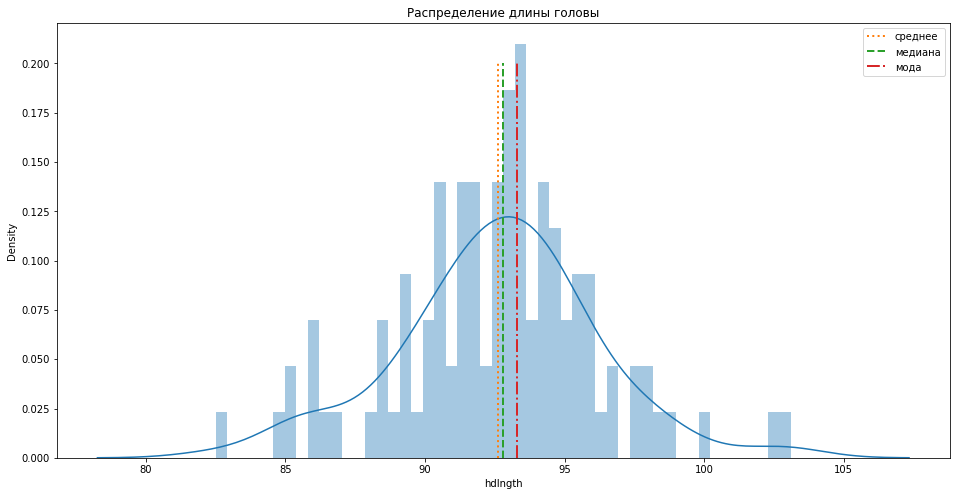

In [8]:
target_mean = round(df['hdlngth'].mean(), 2)
target_median = df['hdlngth'].median()
target_mode = df['hdlngth'].mode()[0]

plt.figure(figsize = (16, 8))

sns.distplot(df['hdlngth'], bins=50)

y = np.linspace(0, 0.2, 2)
plt.plot([target_mean]*2, y, label='среднее', linestyle=':',  linewidth=2)
plt.plot([target_median]*2, y, label='медиана', linestyle='--',  linewidth=2)
plt.plot([target_mode]*2, y, label='мода', linestyle='-.', linewidth=2)

plt.title('Распределение длины головы')
plt.legend()

Из диаграммы видно что целевая переменная имеет нормальное распределение. Также можно судить о наличии выбросов, с которыми позднее необходимо поработать.

In [9]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f64e494f250>,
      dtype=object)

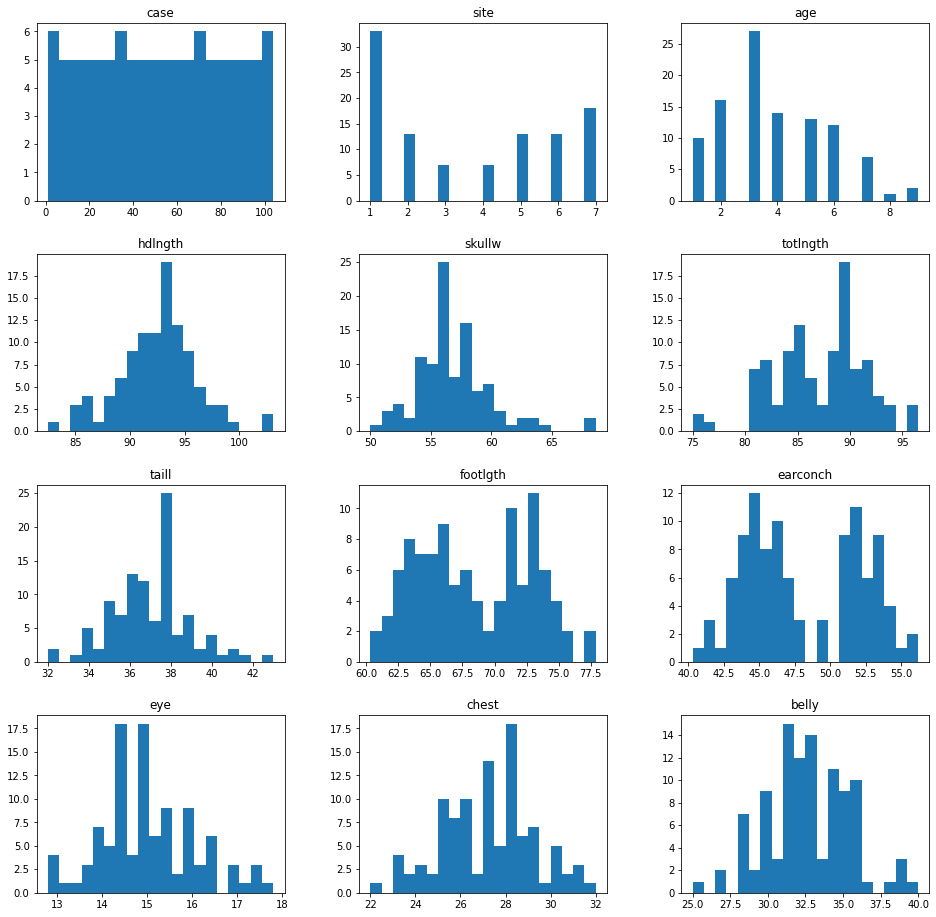

In [10]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False)

# Замена пропусков

Проверяем общее количество пропущенных значений.

In [11]:
df.isnull().sum()

case        0
site        0
pop         0
sex         0
age         2
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    1
earconch    0
eye         0
chest       0
belly       0
dtype: int64

In [12]:
df['age'].value_counts()

3.0    27
2.0    16
4.0    14
5.0    13
6.0    12
1.0    10
7.0     7
9.0     2
8.0     1
Name: age, dtype: int64

Пропущенные значения в возрасте заменим медианой, а длину ноги средним.

In [13]:
df['age'] = df['age'].fillna(df['age'].median())
df['footlgth'] = df['footlgth'].fillna(df['footlgth'].mean())

In [14]:
df.isnull().sum()

case        0
site        0
pop         0
sex         0
age         0
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    0
earconch    0
eye         0
chest       0
belly       0
dtype: int64

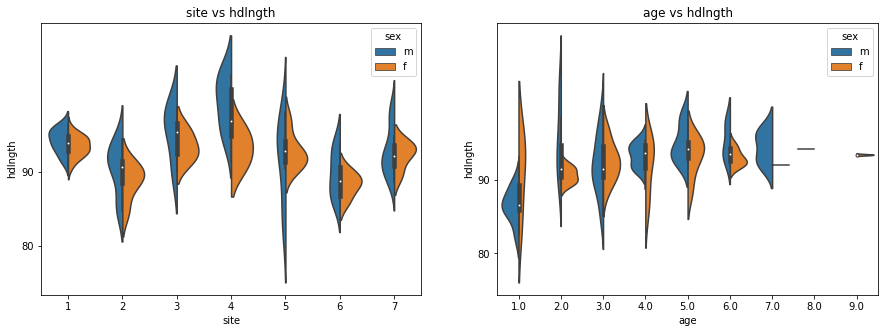

In [15]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.violinplot("site", "hdlngth", hue="sex", data=df, split=True, ax=ax[0])
ax[0].set_title('site vs hdlngth')
ax[0].set_yticks(range(80, 100, 10))
sns.violinplot("age", "hdlngth", hue="sex", data=df, split=True, ax=ax[1])
ax[1].set_title('age vs hdlngth')
ax[1].set_yticks(range(80, 100, 10))
plt.show()

График рассеяния, показывающий, как общая длина опоссумов зависит от длины их головы и ширины черепа

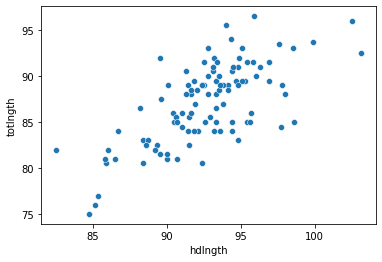

In [16]:
sns.scatterplot(data = df, x = "hdlngth", y = "totlngth")

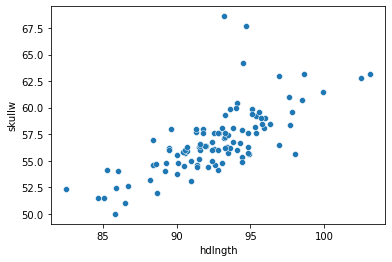

In [17]:
sns.scatterplot(data = df, x = "hdlngth", y = "skullw")

Можно сделать вывод, что существует линейная зависимость между длиной головы и остальными показателями.

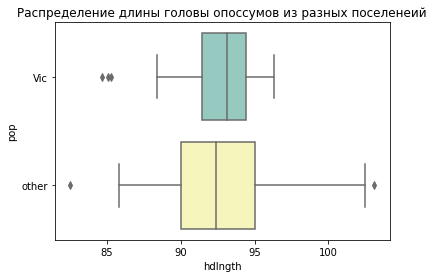

In [18]:
sns.boxplot(x = "hdlngth", y = "pop", data = df, palette = "Set3")
plt.title("Распределение длины головы опоссумов из разных поселенеий");

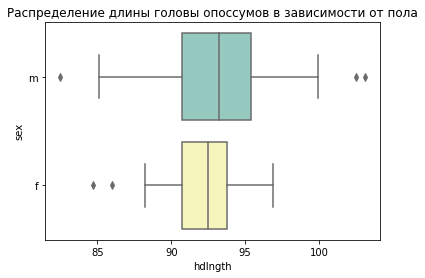

In [19]:
sns.boxplot(x = "hdlngth", y = "sex", data = df, palette = "Set3")
plt.title("Распределение длины головы опоссумов в зависимости от пола");

У самок опоссумов длина головы меньше, чем у мужчин

#Корреляция признаков

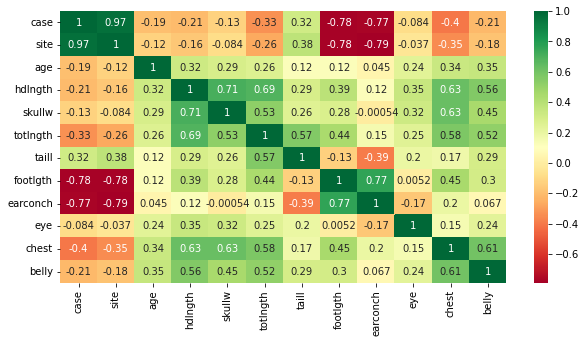

In [20]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Из таблицы корреляции видно, что несколько признаков хорошо коррелируют между собой.

#Feature Engineering

Трансформация строк в числа

In [21]:
df['pop'].replace(['other', 'Vic'], [0, 1], inplace=True)
df['sex'].replace(['m', 'f'], [0, 1], inplace=True)

Удаление ненужных признаков

Удалим порядковый номер экземпляра, он не несет никакого смысла в качестве признака для обучения модели.

In [22]:
df.drop(['case'], axis=1, inplace=True)

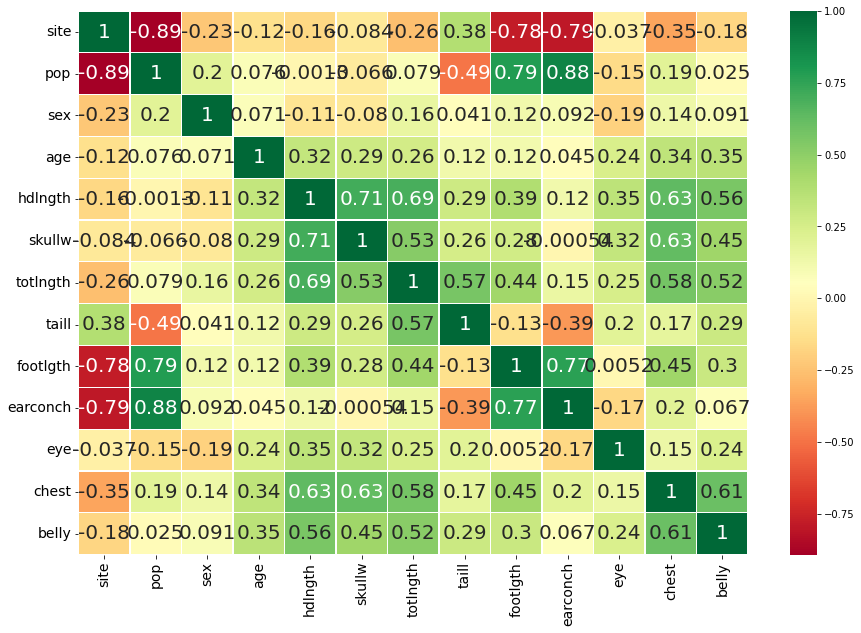

In [23]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Обучение модели

Разобьём нашу выборку на обучающую и тестовую.

In [24]:
y = df["hdlngth"]
X = df.drop(columns=["hdlngth"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Масштабируем признаки перед обучением модели. Для этого воспользуемся трансформером StandardScaler.

В датасете остались только числовые признаки, поэтому масштабируем весь набор данных.

In [25]:
scaler = StandardScaler()  # воспользуемся стандартным трансформером

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train_scaled = scaler.fit_transform(X_train)

# масштабируем тестовую выборку используя статистики обучающей выборки
X_test_scaled = scaler.transform(X_test)

Функцию gradient_descent(X, y), которая по заданной обучающей выборке обучает модель линейной регрессии, оптимизируя функционал методом градиентного спуска (Batch Gradient Descent, GD) и возвращая вектор весов w. В качестве функционала можно выбрать, например, функцию ошибок MSE + L2-регуляризатор. Использовать матрично-векторные операции для вычисления градиента.

In [26]:
np.random.seed(1234)

Таблица для результатов обучения моделей

In [27]:
df_2 = pd.DataFrame(columns=['train_MSE', 'test_MSE', 'train_RMSE', 'test_RMSE', 'train_R2', 'test_R2'])

In [28]:
# реализуем функцию, определяющую среднеквадратичную ошибку
def mserror(X, w, y_pred):
    y = X.dot(w.T)
    return np.sum((y - y_pred)**2) / y_pred.shape[0]

In [29]:
def mserror_grad(X, w, y_pred):
  return 2*(X.dot(w.T)-y_pred).T.dot(X)/y_pred.shape[0]

In [30]:
def r2(X, w, y_pred):
    y = X.dot(w.T)
    return  r2_score(y, y_pred)

In [32]:
def gradient_descent(X, y):
  w = np.zeros(12)
  w_list = [w.copy()] # список векторов весов после каждой итерации
  errors = [] # список значений ошибок после каждой итерации
  eta = 0.000045 # шаг градиентного спуска
  max_iter = 1e4 # максимальное число итераций
  min_weight_dist = 1e-8 # критерий сходимости (разница весов, при которой алгоритм останавливается)
  weight_dist = np.inf # зададим начальную разницу весов большим числом
  iter_num = 0 # счетчик итераций
# ход градиентного спуска
  while weight_dist > min_weight_dist and iter_num < max_iter:
    new_w = w - eta * mserror_grad(X, w, y)
    weight_dist = np.linalg.norm(new_w - w)
    w_list.append(new_w.copy())
    cur_error = mserror(X, new_w, y)
    #print('current_error: {0}'.format(cur_error))
    errors.append(mserror(X, new_w, y))
    mse = round(errors[-1], 4)
    rmse = round(sqrt(mse),4)
    r_2 = round(r2(X, new_w, y),4)
    iter_num += 1
    w = new_w
    #metrics_list = []
    #metrics_list = [mse, rmse, r_2]
  w_list = np.array(w_list)
  print(f'MSE:{mse}') 
  print(f'RMSE: {rmse}')
  print(f'R_2: {r_2}')
  return mse, rmse, r_2, w_list[-1] 

In [33]:
tr_mse, tr_rmse, tr_r2, w_tr = gradient_descent(X_train, y_train)

MSE:3.642
RMSE: 1.9084
R_2: 0.6832


In [34]:
t_mse, t_rmse, t_r2, w_t = gradient_descent(X_test, y_test)

MSE:2.5922
RMSE: 1.61
R_2: 0.7531


In [35]:
df_2.loc['Gradient_descent'] = [tr_mse, t_mse, tr_rmse, t_rmse, tr_r2, t_r2]

In [36]:
def mserror_stohastic_grad(X, w, y_pred):
  i=np.random.randint(X.shape[0])
  x=X[i:i+1, :]
  return 2*(X.dot(w.T)-y_pred[i:i+1, :]).T.dot(x)

In [37]:
def stohastic_gradient_descent(X, y):
  st_w = np.zeros(12) # инициализируем начальный вектор весов
  st_w_list = [st_w.copy()] # список векторов весов после каждой итерации
  st_errors = [] # список значений ошибок после каждой итерации
  st_eta = 0.000045 # шаг градиентного спуска
  st_max_iter = 1e4 # максимальное число итераций
  st_min_weight_dist = 1e-8 # критерий сходимости (разница весов, при которой алгоритм останавливается)
  st_weight_dist = np.inf # зададим начальную разницу весов большим числом
  st_iter_num = 0 # счетчик итераций 
  # ход стохастического градиентного спуска
  while st_weight_dist > st_min_weight_dist and st_iter_num < st_max_iter:
    st_new_w = st_w - st_eta * mserror_stohastic_grad(X, st_w, y)
    st_weight_dist = np.linalg.norm(st_new_w - st_w, ord=2)
    st_w_list.append(st_new_w.copy())
    cur_error = mserror(X, st_new_w, y)
    st_errors.append(cur_error)
    mse = round(st_errors[-1], 4)
    rmse = round(sqrt(mse),4)
    r_2 = round(r2(X, st_new_w, y),4)
    st_iter_num += 1
    st_w = st_new_w
  st_w_list = np.array(st_w_list)
  print(f'MSE:{mse}') 
  print(f'RMSE: {rmse}')
  print(f'R_2: {r_2}')
  return mse, rmse, r_2, st_w_list[-1] 

Отберем 5 наиболее значимых признаков для обучения модели с помощью recursive feature elimination (RFE).

In [38]:
# отберём с помощью RFE 5 признаков
estimator=LinearRegression()
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X_train, y_train)
# выведем эти 5 признаков
print('Selected features: %s' % list(X_train.columns[selector.support_]))

Selected features: ['pop', 'sex', 'footlgth', 'eye', 'chest']


Выберем оптимальное количество признаков кросс-валидацией с помощью RFECV

Optimal number of features: 12
Selected features: ['site', 'pop', 'sex', 'age', 'skullw', 'totlngth', 'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly']


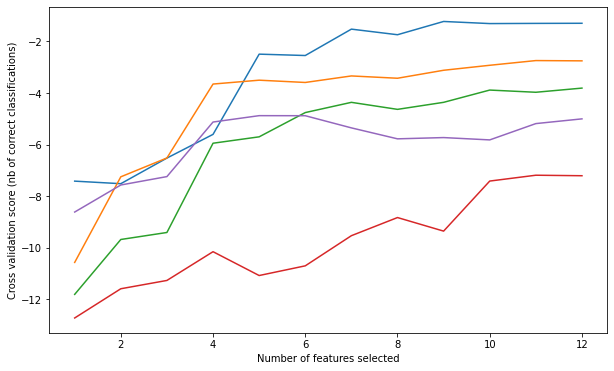

In [39]:
rfecv = RFECV(estimator=LinearRegression(), step=1, cv=5, scoring='neg_mean_squared_error')
rfecv = rfecv.fit(X_train, y_train)

selected_features = list(X_train.columns[rfecv.support_])

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % selected_features)

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Optimal number of features: 12
Selected features: ['site', 'pop', 'sex', 'age', 'skullw', 'totlngth', 'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly']


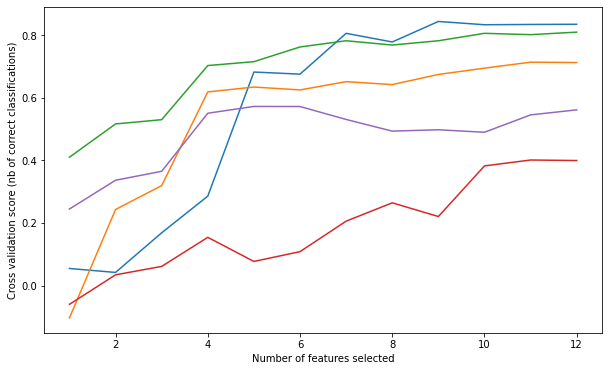

In [40]:
rfecv = RFECV(estimator=LinearRegression(), step=1, cv=5, scoring='r2')
rfecv = rfecv.fit(X_train, y_train)

selected_features = list(X_train.columns[rfecv.support_])

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % selected_features)

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Выбор оптимального количества признаков кросс-валидацией с помощью RFECV двумя выбранными скорингами (MSE и r2) показывает одинаковые результаты. Предлагается использовать все 12 признаков датасета.Хотя, из графика видно что использование 10-11 фичей приведет к не сильно бОльшим потерям. На данном наборе данных (т.к. он небольшой) нет смысла убирать какой-то из признаков, т.к. эта операция не даст большой экономии временных и мощностных затрат. Соответственно, для обучения будут использованы все признаки датасета.

In [41]:
model = Ridge()
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [42]:
df_2.loc['Ridge'] = [('%.4f' % mean_squared_error(y_train, y_train_pred)), ('%.4f' % mean_squared_error(y_test, y_test_pred)), ('%.4f' % sqrt(mean_squared_error(y_train, y_train_pred))), ('%.4f' % sqrt(mean_squared_error(y_test, y_test_pred))), ('%.4f' % r2_score(y_train, y_train_pred)), ('%.4f' % r2_score(y_test, y_test_pred))]

In [43]:
model = Ridge()
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

In [44]:
df_2.loc['Ridge_scaled'] = [('%.4f' % mean_squared_error(y_train, y_train_pred)), ('%.4f' % mean_squared_error(y_test, y_test_pred)), ('%.4f' % sqrt(mean_squared_error(y_train, y_train_pred))), ('%.4f' % sqrt(mean_squared_error(y_test, y_test_pred))), ('%.4f' % r2_score(y_train, y_train_pred)), ('%.4f' % r2_score(y_test, y_test_pred))]

Подбор гиперпараметров модели

Text(0, 0.5, 'CV score')

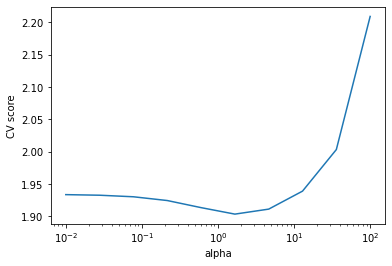

In [45]:
alpha_grid = np.logspace(-2, 2, 10)
searcher = GridSearchCV(Ridge(), [{"alpha": alpha_grid}], scoring="neg_root_mean_squared_error", cv=5)
searcher.fit(X_train_scaled, y_train)

plt.plot(alpha_grid, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [46]:
best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

Best alpha = 1.6681


In [47]:
simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Ridge(best_alpha))
])
model = simple_pipeline.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
df_2.loc['Ridge_GridSearch_scale'] = [('%.4f' % mean_squared_error(y_train, y_train_pred)), ('%.4f' % mean_squared_error(y_test, y_test_pred)), ('%.4f' % sqrt(mean_squared_error(y_train, y_train_pred))), ('%.4f' % sqrt(mean_squared_error(y_test, y_test_pred))), ('%.4f' % r2_score(y_train, y_train_pred)), ('%.4f' % r2_score(y_test, y_test_pred))]

In [48]:
simple_pipeline = Pipeline([
    ('regression', Ridge(best_alpha))
])
model = simple_pipeline.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
df_2.loc['Ridge_GridSearch_not_scale'] = [('%.4f' % mean_squared_error(y_train, y_train_pred)), ('%.4f' % mean_squared_error(y_test, y_test_pred)), ('%.4f' % sqrt(mean_squared_error(y_train, y_train_pred))), ('%.4f' % sqrt(mean_squared_error(y_test, y_test_pred))), ('%.4f' % r2_score(y_train, y_train_pred)), ('%.4f' % r2_score(y_test, y_test_pred))]

Кросс-валидация

In [49]:
df_1 = pd.DataFrame(columns=['Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5', 'E', 'STD'])
cv_scores_train_mse = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="neg_mean_squared_error")
cv_scores_train_mse = -cv_scores_train_mse
df_1.loc['mse-train'] = [cv_scores_train_mse[0], cv_scores_train_mse[1], cv_scores_train_mse[2], cv_scores_train_mse[3], cv_scores_train_mse[4], ('%.4f' % np.mean(cv_scores_train_mse)), ('%.4f' % np.std(cv_scores_train_mse))]
cv_scores_test_mse = cross_val_score(model, X_test_scaled, y_test, cv=5, scoring="neg_mean_squared_error")
cv_scores_test_mse = -cv_scores_test_mse
df_1.loc['mse-test'] = [cv_scores_test_mse[0], cv_scores_test_mse[1], cv_scores_test_mse[2], cv_scores_test_mse[3], cv_scores_test_mse[4], ('%.4f' % np.mean(cv_scores_test_mse)), ('%.4f' % np.std(cv_scores_test_mse))]
cv_scores_train_rmse = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="neg_root_mean_squared_error")
cv_scores_train_rmse = -cv_scores_train_rmse
df_1.loc['rmse-train'] = [cv_scores_train_rmse[0], cv_scores_train_rmse[1], cv_scores_train_rmse[2], cv_scores_train_rmse[3], cv_scores_train_rmse[4], ('%.4f' % np.mean(cv_scores_train_rmse)), ('%.4f' % np.std(cv_scores_train_rmse))]
cv_scores_test_rmse = cross_val_score(model, X_test_scaled, y_test, cv=5, scoring="neg_root_mean_squared_error")
cv_scores_test_rmse = -cv_scores_test_rmse
df_1.loc['rmse-test'] = [cv_scores_test_rmse[0], cv_scores_test_rmse[1], cv_scores_test_rmse[2], cv_scores_test_rmse[3], cv_scores_test_rmse[4], ('%.4f' % np.mean(cv_scores_test_rmse)), ('%.4f' % np.std(cv_scores_test_rmse))]
cv_scores_train_r2 = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="r2")
df_1.loc['r2-train'] = [cv_scores_train_r2[0], cv_scores_train_r2[1], cv_scores_train_r2[2], cv_scores_train_r2[3], cv_scores_train_r2[4], ('%.4f' % np.mean(cv_scores_train_r2)), ('%.4f' % np.std(cv_scores_train_r2))]
cv_scores_test_r2 = cross_val_score(model, X_test_scaled, y_test, cv=5, scoring="r2")
df_1.loc['r2-test'] = [cv_scores_test_r2[0], cv_scores_test_r2[1], cv_scores_test_r2[2], cv_scores_test_r2[3], cv_scores_test_r2[4], ('%.4f' % np.mean(cv_scores_test_r2)), ('%.4f' % np.std(cv_scores_test_r2))]
df_1

,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,E,STD
mse-train,1.176032,2.807403,3.950430,6.743557,4.720323,3.8795,1.8640
mse-test,6.576523,5.789316,10.890391,0.330402,9.772813,6.6719,3.6990
rmse-train,1.084450,1.675531,1.987569,2.596836,2.172631,1.9034,0.5066
rmse-test,2.564473,2.406100,3.300059,0.574806,3.126150,2.3943,0.9691
r2-train,0.850041,0.706756,0.802539,0.437912,0.585911,0.6766,0.1497
r2-test,-0.516493,0.108458,0.238562,0.905426,0.688827,0.2850,0.4947


In [50]:
df_2.loc['Ridge_cross_val'] = [('%.4f' % np.mean(cv_scores_train_mse)), ('%.4f' % np.mean(cv_scores_test_mse)), ('%.4f' % np.mean(cv_scores_train_rmse)), ('%.4f' % np.mean(cv_scores_test_rmse)), ('%.4f' % np.mean(cv_scores_train_r2)), ('%.4f' % np.mean(cv_scores_test_r2))]

Сводная таблица показателей метрик качества модели по всем вариантам обученных моделей.

In [51]:
df_2

,train_MSE,test_MSE,train_RMSE,test_RMSE,train_R2,test_R2
Gradient_descent,3.642,2.5922,1.9084,1.61,0.6832,0.7531
Ridge,2.8556,4.8721,1.6899,2.2073,0.7754,0.6070
Ridge_scaled,2.8082,5.0062,1.6758,2.2375,0.7792,0.5962
Ridge_GridSearch_scale,2.8246,4.9937,1.6806,2.2347,0.7779,0.5972
Ridge_GridSearch_not_scale,2.8991,4.8353,1.7027,2.1989,0.7720,0.6100
Ridge_cross_val,3.8795,6.6719,1.9034,2.3943,0.6766,0.2850


Из таблицы видно, что на обучающей выборке лучше отработала модель Ridge_scaled. А вот на тестовых данных с лучшими показателями отработал Gradient_descent.